In [ ]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
gics = pd.read_excel('/content/GICS.xlsx')
gics['Date'] = pd.to_datetime(gics['Date'])
gics = gics.set_index('Date')
gics.head()

,Energy,Utilities,IT,Materials,Industrials,ConsumerDiscretionary,ConsumerStaples,healthcare,Financials,CommunicationServices,RealEstate,sp500,wti_spot,VIX,FedFunds,inflation_yoy,UNRATE,INDPRO
Date,,,,,,,,,,,,,,,,,,
2005-01-07,279.00,137.31,318.82,177.15,282.06,271.24,237.46,345.72,404.77,126.39,115.03,1186.19,44.07,13.49,2.14,0.028449,5.3,95.8785
2005-01-14,288.84,139.93,316.34,178.17,280.46,272.62,238.60,344.68,400.20,122.03,114.63,1184.52,46.79,12.43,2.25,0.028449,5.3,95.8785
2005-01-21,287.36,139.53,307.49,175.74,275.18,266.17,237.98,340.69,396.96,120.75,115.50,1167.87,47.85,14.36,2.28,0.028449,5.3,95.8785
2005-01-28,293.39,142.75,308.91,175.57,278.66,264.30,239.43,338.96,396.53,119.34,111.19,1171.36,48.56,13.24,2.27,0.028449,5.3,95.8785
2005-02-04,311.19,147.91,316.27,181.67,283.76,269.95,243.74,345.94,408.69,123.30,115.11,1203.03,46.97,11.21,2.43,0.030530,5.4,96.5709


In [ ]:
gics.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1049 entries, 2005-01-07 to NaT
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Energy                 1043 non-null   float64
 1   Utilities              1043 non-null   float64
 2   IT                     1043 non-null   float64
 3   Materials              1043 non-null   float64
 4   Industrials            1043 non-null   float64
 5   ConsumerDiscretionary  1043 non-null   float64
 6   ConsumerStaples        1043 non-null   float64
 7   healthcare             1043 non-null   float64
 8   Financials             1043 non-null   float64
 9   CommunicationServices  1043 non-null   float64
 10  RealEstate             1043 non-null   float64
 11  sp500                  1043 non-null   float64
 12  wti_spot               1043 non-null   float64
 13  VIX                    1043 non-null   float64
 14  FedFunds               1043 non-null   float6

In [ ]:
gics = gics[['sp500',	'wti_spot',	'VIX',	'FedFunds',	'inflation_yoy',	'UNRATE',	'INDPRO']]

In [ ]:
gics.head()

,sp500,wti_spot,VIX,FedFunds,inflation_yoy,UNRATE,INDPRO
Date,,,,,,,
2005-01-07,1186.19,44.07,13.49,2.14,0.028449,5.3,95.8785
2005-01-14,1184.52,46.79,12.43,2.25,0.028449,5.3,95.8785
2005-01-21,1167.87,47.85,14.36,2.28,0.028449,5.3,95.8785
2005-01-28,1171.36,48.56,13.24,2.27,0.028449,5.3,95.8785
2005-02-04,1203.03,46.97,11.21,2.43,0.030530,5.4,96.5709


In [ ]:
gics.loc[:,'ret_sp500'] = np.log(gics['sp500']).diff()
gics.loc[:,'delta_oil'] = np.log(gics['wti_spot']).diff()

In [ ]:
scaler = StandardScaler()
gics[['VIX', 'FedFunds', 'inflation_yoy', 'UNRATE', 'INDPRO']] = scaler.fit_transform(
    gics[['VIX', 'FedFunds', 'inflation_yoy', 'UNRATE', 'INDPRO']])

## **Quantile Regression**

In [ ]:
formula = 'ret_sp500 ~ delta_oil + VIX + FedFunds + inflation_yoy + UNRATE + INDPRO'
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

models = {}
for q in quantiles:
    mod = smf.quantreg(formula, data=gics)
    res = mod.fit(q=q)
    models[q] = res
    print(f"\n=== Quantile: {q} ===")
    print(res.summary())


=== Quantile: 0.1 ===
                         QuantReg Regression Results                          
Dep. Variable:              ret_sp500   Pseudo R-squared:               0.3478
Model:                       QuantReg   Bandwidth:                    0.007515
Method:                 Least Squares   Sparsity:                      0.06928
Date:                Sat, 21 Jun 2025   No. Observations:                 1042
Time:                        03:10:58   Df Residuals:                     1035
                                        Df Model:                            6
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0232      0.001    -35.781      0.000      -0.024      -0.022
delta_oil         0.0337      0.005      7.469      0.000       0.025       0.043
VIX              -0.0240      0.001    -27.225      0.000      -0.026      -0.022
FedFunds      

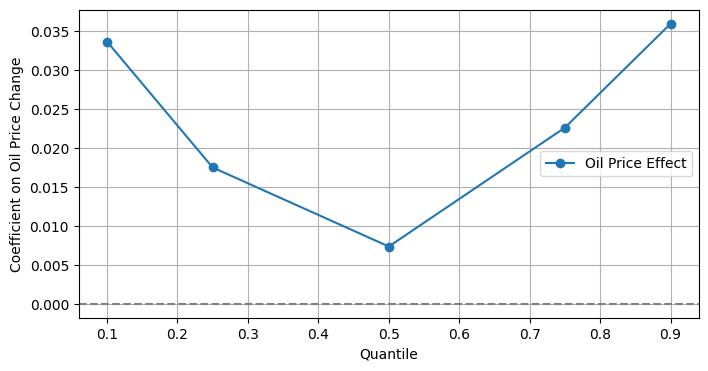

In [ ]:
betas = [models[q].params['delta_oil'] for q in quantiles]
plt.figure(figsize=(8, 4))
plt.plot(quantiles, betas, marker='o', label='Oil Price Effect')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Quantile')
plt.ylabel('Coefficient on Oil Price Change')
plt.title('Oil Price Impact on S&P 500 Returns Across Quantiles')
plt.grid(True)
plt.legend()
plt.show()

## **Endogeneity Test**

In [ ]:
# 1st stage regression
first_stage = smf.ols(
    'delta_oil ~ wti_spot + VIX + FedFunds + inflation_yoy + UNRATE + INDPRO',
    data=gics).fit()

# Save residuals (these capture the endogenous part of delta_oil)
gics['resid_endog'] = first_stage.resid

## ***Second-Stage Regression***

In [ ]:
formula_augmented = 'ret_sp500 ~ delta_oil + resid_endog + VIX + FedFunds + inflation_yoy + UNRATE + INDPRO'
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
for q in quantiles:
    mod_aug = smf.quantreg(formula_augmented, data=gics)
    res_aug = mod_aug.fit(q=q)
    print(f"\n=== Endogeneity Test (DWH) at Quantile: {q} ===")
    print(res_aug.summary2().tables[1].loc['resid_endog'])



=== Endogeneity Test (DWH) at Quantile: 0.1 ===
Coef.       0.656615
Std.Err.    0.152328
t           4.310541
P>|t|       0.000018
[0.025      0.357708
0.975]      0.955522
Name: resid_endog, dtype: float64

=== Endogeneity Test (DWH) at Quantile: 0.25 ===
Coef.       0.583647
Std.Err.    0.174826
t           3.338453
P>|t|       0.000873
[0.025      0.240593
0.975]      0.926700
Name: resid_endog, dtype: float64

=== Endogeneity Test (DWH) at Quantile: 0.5 ===
Coef.       0.591805
Std.Err.    0.178476
t           3.315890
P>|t|       0.000945
[0.025      0.241590
0.975]      0.942021
Name: resid_endog, dtype: float64

=== Endogeneity Test (DWH) at Quantile: 0.75 ===
Coef.       0.492038
Std.Err.    0.195705
t           2.514185
P>|t|       0.012082
[0.025      0.108014
0.975]      0.876062
Name: resid_endog, dtype: float64

=== Endogeneity Test (DWH) at Quantile: 0.9 ===
Coef.       0.121093
Std.Err.    0.219843
t           0.550819
P>|t|       0.581877
[0.025     -0.310295
0.975]  

## **regression-based approach**

In [ ]:
formula_augmented = 'ret_sp500 ~ delta_oil + resid_endog + VIX + FedFunds + inflation_yoy + UNRATE + INDPRO'

quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
for q in quantiles:
    mod_aug = smf.quantreg(formula_augmented, data=gics)
    res_aug = mod_aug.fit(q=q)
    print(f"\n=== Endogeneity Test (Regression-Based DWH) at Quantile: {q} ===")
    print(res_aug.summary2().tables[1].loc['resid_endog'])


=== Endogeneity Test (Regression-Based DWH) at Quantile: 0.1 ===
Coef.       0.656615
Std.Err.    0.152328
t           4.310541
P>|t|       0.000018
[0.025      0.357708
0.975]      0.955522
Name: resid_endog, dtype: float64

=== Endogeneity Test (Regression-Based DWH) at Quantile: 0.25 ===
Coef.       0.583647
Std.Err.    0.174826
t           3.338453
P>|t|       0.000873
[0.025      0.240593
0.975]      0.926700
Name: resid_endog, dtype: float64

=== Endogeneity Test (Regression-Based DWH) at Quantile: 0.5 ===
Coef.       0.591805
Std.Err.    0.178476
t           3.315890
P>|t|       0.000945
[0.025      0.241590
0.975]      0.942021
Name: resid_endog, dtype: float64

=== Endogeneity Test (Regression-Based DWH) at Quantile: 0.75 ===
Coef.       0.492038
Std.Err.    0.195705
t           2.514185
P>|t|       0.012082
[0.025      0.108014
0.975]      0.876062
Name: resid_endog, dtype: float64

=== Endogeneity Test (Regression-Based DWH) at Quantile: 0.9 ===
Coef.       0.121093
Std.Err

## **IVQR**

In [ ]:
# First-stage OLS
first_stage_formula = 'delta_oil ~ wti_spot + VIX + FedFunds + inflation_yoy + UNRATE + INDPRO'
first_stage = smf.ols(first_stage_formula, data=gics).fit()

gics['resid_iv'] = first_stage.resid
quantiles = [0.1, 0.25, 0.5, 0.75]
ivqr_models = {}

for q in quantiles:
    formula_ivqr = 'ret_sp500 ~ delta_oil + VIX + FedFunds + inflation_yoy + UNRATE + INDPRO + resid_iv'
    # Estimate quantile regression
    mod = smf.quantreg(formula_ivqr, data=gics)
    res = mod.fit(q=q)
    ivqr_models[q] = res
    print(f"\n=== IVQR Results at Quantile {q} ===")
    print(res.summary())


=== IVQR Results at Quantile 0.1 ===
                         QuantReg Regression Results                          
Dep. Variable:              ret_sp500   Pseudo R-squared:               0.3519
Model:                       QuantReg   Bandwidth:                    0.007640
Method:                 Least Squares   Sparsity:                      0.06635
Date:                Sat, 21 Jun 2025   No. Observations:                 1042
Time:                        03:11:23   Df Residuals:                     1034
                                        Df Model:                            7
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0225      0.001    -35.898      0.000      -0.024      -0.021
delta_oil        -0.6306      0.152     -4.146      0.000      -0.929      -0.332
VIX              -0.0336      0.002    -13.870      0.000      -0.038      -0.029

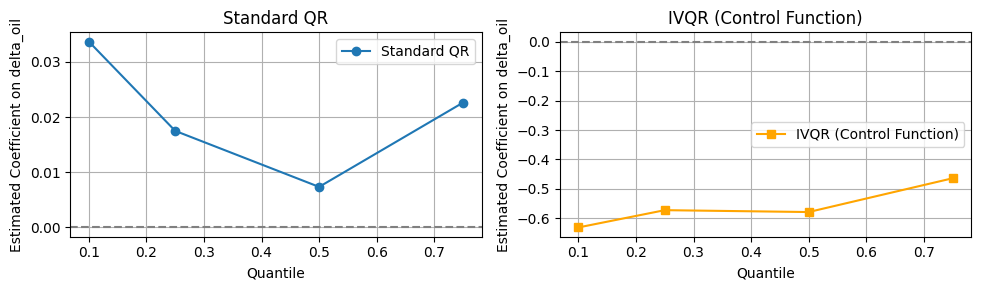

In [ ]:
qr_betas = [models[q].params['delta_oil'] for q in quantiles]
ivqr_betas = [ivqr_models[q].params['delta_oil'] for q in quantiles]

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].plot(quantiles, qr_betas, label='Standard QR', marker='o')
axes[0].set_xlabel('Quantile')
axes[0].set_ylabel('Estimated Coefficient on delta_oil')
axes[0].set_title('Standard QR')
axes[0].axhline(0, color='gray', linestyle='--')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(quantiles, ivqr_betas, label='IVQR (Control Function)', marker='s', color='orange')
axes[1].set_xlabel('Quantile')
axes[1].set_ylabel('Estimated Coefficient on delta_oil')
axes[1].set_title('IVQR (Control Function)')
axes[1].axhline(0, color='gray', linestyle='--')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()